# Import libraries

In [116]:
import pandas as pd
import numpy as np
import os
import config
from joblib import dump, load
import functools
import itertools
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Rectangle
from scipy.stats import wilcoxon, kendalltau
from scipy.stats import mannwhitneyu
from utils import plot_longitudinal, get_diversity

# Set constants

In [106]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Load data

In [107]:
study = "P106"

In [108]:
gmhi2 = load(os.path.join(config.MODEL_DIR, "gmhi2_model.joblib"))
gmhi2

LogisticRegression(C=0.03, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')

In [109]:
X = pd.read_csv(os.path.join(config.CLEAN_DIR, "taxonomic_features_val.csv"), index_col=[0, 1]).loc[study]
X.head()

,k__Archaea,k__Archaea|p__Euryarchaeota,k__Archaea|p__Euryarchaeota|c__Methanobacteria,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanosphaera|s__Methanosphaera_stadtmanae,k__Archaea|p__Euryarchaeota|c__Thermoplasmata,...,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Hordeivirus|s__Barley_stripe_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cactus_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Cucumber_green_mottle_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Paprika_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Pepper_mild_mottle_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Virgaviridae|g__Tobamovirus|s__Tobacco_mild_green_mosaic_virus,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Deep_sea_thermophilic_phage_D6E,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Loktanella_phage_pCB2051_A,k__Viruses|p__Viruses_unclassified|c__Viruses_unclassified|o__Viruses_unclassified|f__Viruses_unclassified|g__Viruses_unclassified|s__Tetraselmis_viridis_virus_S1
Sample Accession,,,,,,,,,,,,,,,,,,,,,
SAMEA7082340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082341,0.018776,0.018776,0.018776,0.018776,0.018776,0.018776,0.018776,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082342,0.013714,0.013714,0.013714,0.013714,0.013714,0.013714,0.013714,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
SAMEA7082344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


# Compute GMHI2 scores

In [110]:
meta = pd.read_csv(os.path.join(config.CLEAN_DIR, "metadata_val.csv"), index_col=[0, 1, 2]).loc[study]
assert((meta.index.get_level_values(0) == X.index).all())
meta["GMHI2"] = gmhi2.decision_function(X > config.PRESENCE_CUTOFF)
meta.index = meta.index.get_level_values(1)
meta.head()

,health_status/host_diet,timepoint,GMHI2
Subject_ID,,,
11,Irritable bowel syndrome (IBS),0,-0.244169
11,Irritable bowel syndrome (IBS),12,0.170362
11,Irritable bowel syndrome (IBS),6,0.435302
12,Irritable bowel syndrome (IBS),0,1.398699
12,Irritable bowel syndrome (IBS),12,1.675695


# Compute other indices

In [111]:
meta = get_diversity(meta, X)
meta.head()

,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
Subject_ID,,,,,,
11,Irritable bowel syndrome (IBS),0,-0.244169,81,2.455907,0.113691
11,Irritable bowel syndrome (IBS),12,0.170362,61,2.541360,0.130606
11,Irritable bowel syndrome (IBS),6,0.435302,78,2.601736,0.130187
12,Irritable bowel syndrome (IBS),0,1.398699,84,3.420449,0.046836
12,Irritable bowel syndrome (IBS),12,1.675695,84,2.944088,0.097194


# Plot stuff now 

In [112]:
baseline = meta[(meta["health_status/host_diet"] == "Healthy") | (meta["timepoint"] == "0")]
display(baseline.head())
baseline.tail()

,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
Subject_ID,,,,,,
11,Irritable bowel syndrome (IBS),0,-0.244169,81,2.455907,0.113691
12,Irritable bowel syndrome (IBS),0,1.398699,84,3.420449,0.046836
NaN,Irritable bowel syndrome (IBS),0,0.198890,59,2.371039,0.134652
16,Irritable bowel syndrome (IBS),0,0.839928,69,2.604924,0.107140
18,Irritable bowel syndrome (IBS),0,0.175408,70,2.707975,0.087356


,health_status/host_diet,timepoint,GMHI2,Species Richness,Shannon Diversity,Simpson Diversity
Subject_ID,,,,,,
D-6Fresk_S5,Healthy,NaN,0.794593,64,3.021262,0.063898
D-6Fryst_S4,Healthy,NaN,1.058348,54,2.749086,0.086027
D-7Fryst_S7,Healthy,NaN,1.062195,70,2.420487,0.161644
D-9Feresk_S9,Healthy,NaN,0.351767,50,1.747606,0.337830
D-9Fryst_S2,Healthy,NaN,0.681133,63,2.731925,0.089670


In [113]:
donors = baseline[baseline["health_status/host_diet"] == "Healthy"]
patients = baseline[baseline["health_status/host_diet"] != "Healthy"]
patients = patients.iloc[~patients.index.isna()]

In [114]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

2 donors, 17 samples
22 IBS patients at baseline
MannwhitneyuResult(statistic=139.0, pvalue=0.17852907984771182)


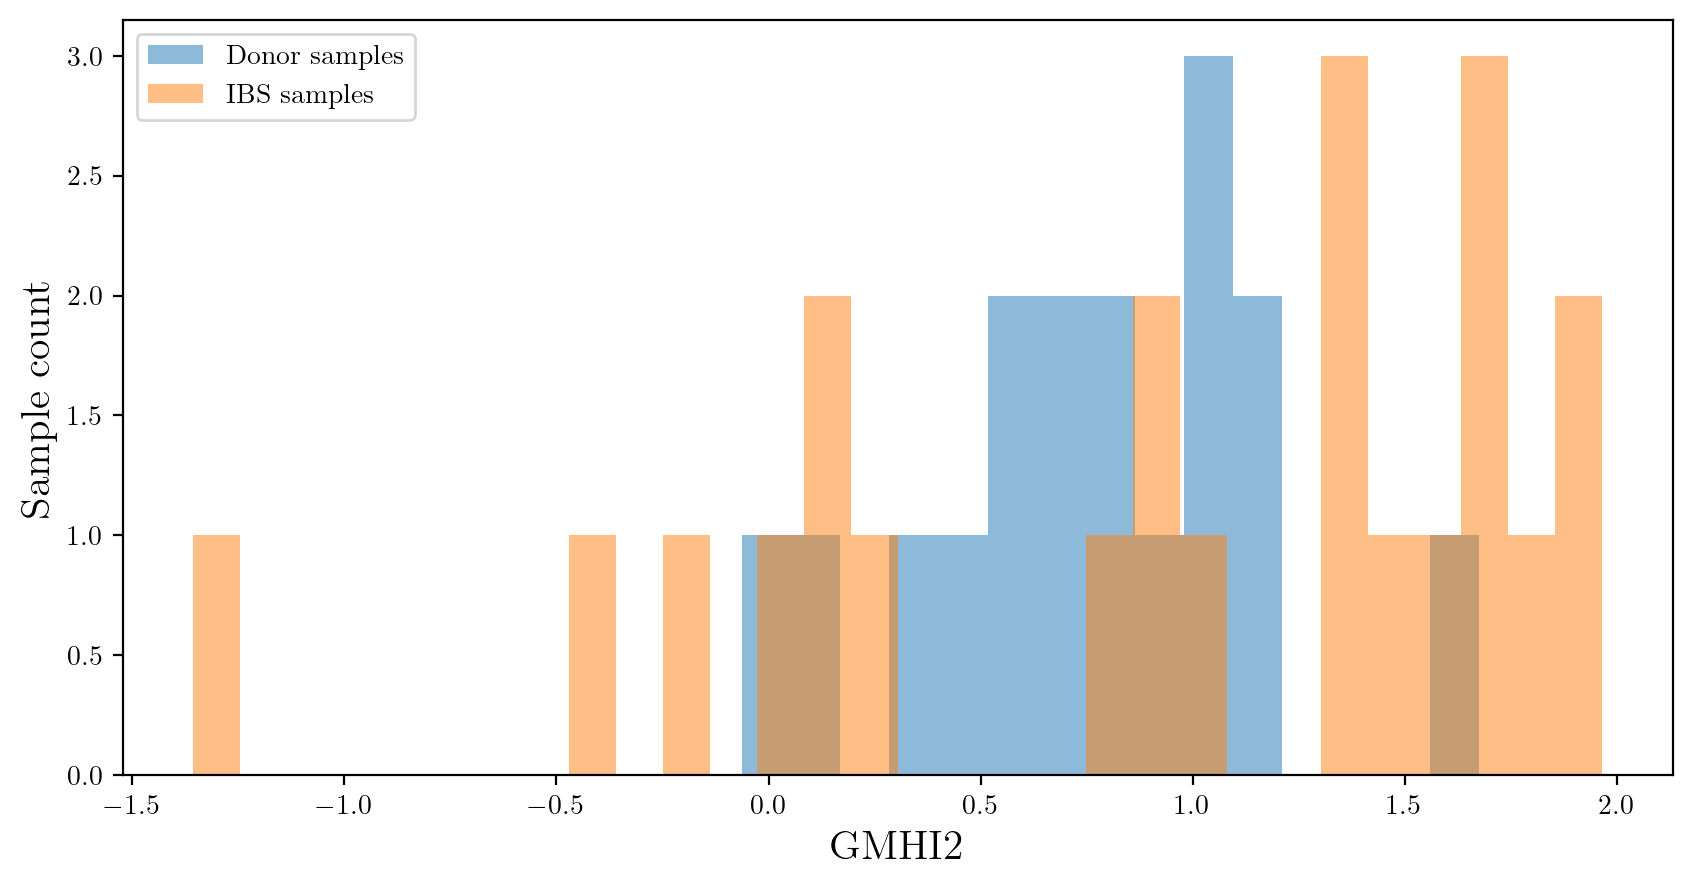

In [117]:
plt.figure(figsize=(10, 5), dpi=200)
donors["GMHI2"].plot.hist(bins=15, alpha=0.5, label="Donor samples")
patients["GMHI2"].plot.hist(bins=30, alpha=0.5, label="IBS samples")
plt.xlabel("GMHI2", fontsize=15)
plt.ylabel("Sample count", fontsize=15)

plt.legend()

print(f"2 donors, {donors.shape[0]} samples")
print(f"{patients.shape[0]} IBS patients at baseline")
stat = mannwhitneyu(donors["GMHI2"], patients["GMHI2"])
print(stat)
plt.savefig(os.path.join(config.FIGURE_DIR, study + "_histogram.svg"))